<img src="https://upload.wikimedia.org/wikipedia/en/thumb/4/48/Hoare_Lea_logo.svg/1280px-Hoare_Lea_logo.svg.png" width=300 />

**Pablo Arango | Computational Designer**

[pabloarango@hoarelea.com](mailto:pabloarango@hoarelea.com)

---

# Wind and Temperature Frenquency Analysis
### Goal
The main goal of this workflows is to aggregate the individual results from ANSYS CFX into the following databases:

### Inputs
The inputs for this workflow are:
- `Input 1`

### Outputs
- `Output 1` 
- `Output 2`


## Import libraries

In [2]:
import pandas as pd
import os
import numpy as np

In [3]:
# GLOBAL VARIABLES
EXPORT_FOLDER = 'export'
WEATHER_FILE = 'data/20-year-data-northolt.xlsx'
WIND_DIR_STEP_DEG = 30 # Step angle in degrees to subdivide the orientations eg 30 => [0, 30, 60 ... 330] 
WIND_QUANTILE = 0.9 # Quantile to use for the wind speed threshold
TEMP_QUANTILE = 0.996 # Quantile to use for the temperature threshold

## Define Functions

In [4]:
from bisect import bisect_left

def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before

### Create export folder

In [5]:
if not os.path.exists(EXPORT_FOLDER):
  os.mkdir(os.path.join(os.getcwd(),EXPORT_FOLDER))

# Read and clean data

In [6]:
df = pd.read_excel(WEATHER_FILE , skiprows=10, header=0)
df.columns = ['date','air_temp','wet_temp','rel_hum','wind_speed', 'wind_dir']
df['date'] = pd.to_datetime(df['date'])
df

,date,air_temp,wet_temp,rel_hum,wind_speed,wind_dir
0,2002-08-01 00:00:00,14.4,13.6,91.0,1.5,200.0
1,2002-08-01 01:00:00,13.3,12.8,94.2,0.5,190.0
2,2002-08-01 02:00:00,13.0,12.7,96.5,0.5,200.0
3,2002-08-01 03:00:00,12.8,12.5,96.4,0.0,0.0
4,2002-08-01 04:00:00,12.4,12.2,97.6,0.0,0.0
...,...,...,...,...,...,...
175315,2022-07-31 19:00:00,24.8,18.8,53.8,3.6,320.0
175316,2022-07-31 20:00:00,23.4,18.6,61.1,4.1,10.0
175317,2022-07-31 21:00:00,21.6,17.9,68.0,4.1,50.0
175318,2022-07-31 22:00:00,20.6,17.5,72.6,4.1,60.0


In [7]:
df.dtypes

date          datetime64[ns]
air_temp             float64
wet_temp             float64
rel_hum              float64
wind_speed           float64
wind_dir             float64
dtype: object

In [8]:
# normalize wind directions to 8
wind_dirs = np.arange(0,361,WIND_DIR_STEP_DEG)
df['norm_dir'] = df['wind_dir'].apply(lambda row: take_closest(wind_dirs, row))
# replace 360 with 0
df['norm_dir'] = df['norm_dir'].apply(lambda row: 0 if row == 360 else row)
df.head()

,date,air_temp,wet_temp,rel_hum,wind_speed,wind_dir,norm_dir
0,2002-08-01 00:00:00,14.4,13.6,91.0,1.5,200.0,210
1,2002-08-01 01:00:00,13.3,12.8,94.2,0.5,190.0,180
2,2002-08-01 02:00:00,13.0,12.7,96.5,0.5,200.0,210
3,2002-08-01 03:00:00,12.8,12.5,96.4,0.0,0.0,0
4,2002-08-01 04:00:00,12.4,12.2,97.6,0.0,0.0,0


# Wind Rose Annual and Seasonal

In [11]:
%%capture

!pip install windrose
!pip install seaborn

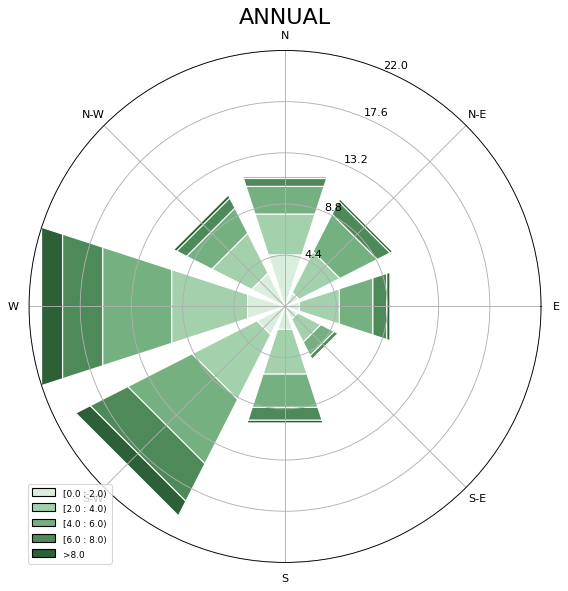

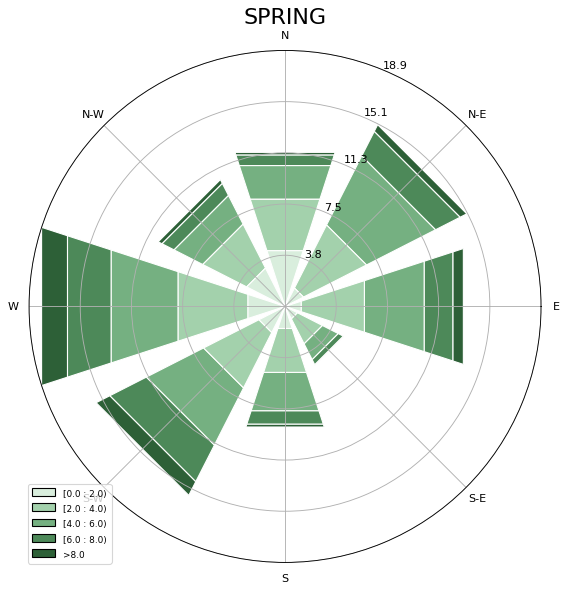

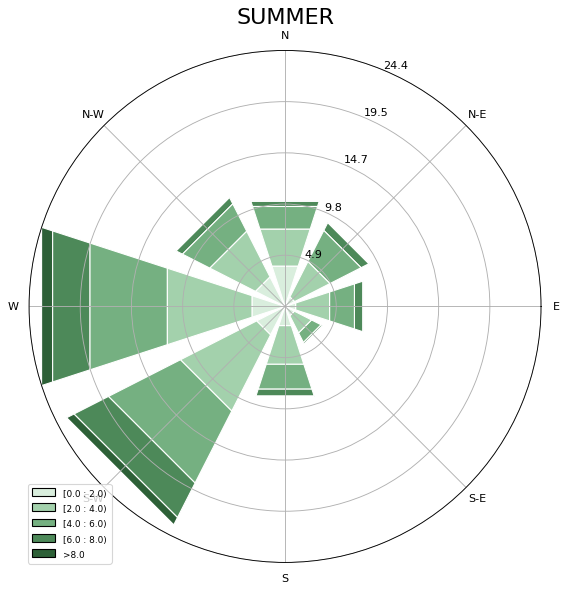

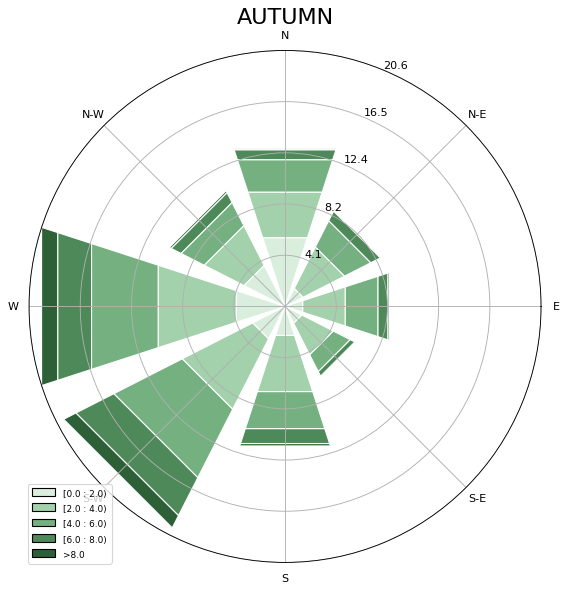

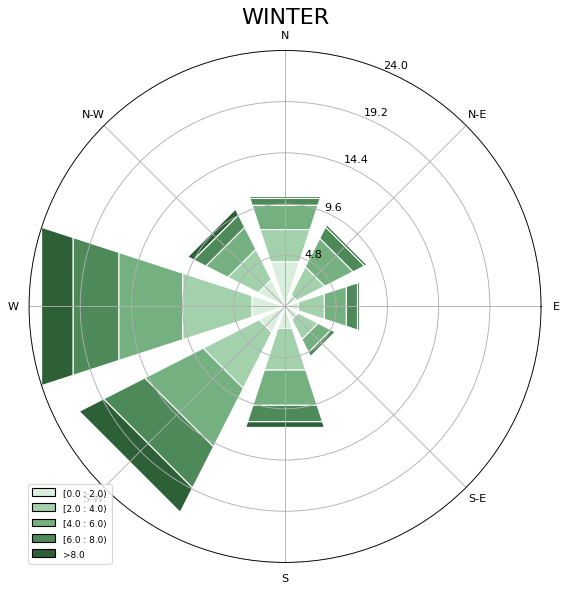

In [15]:
from matplotlib.patches import bbox_artist
from windrose import WindroseAxes
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from windrose import plot_windrose
from windrose import WindroseAxes
import seaborn as sns

seasons = {'annual':list(range(1,13)),
           'spring':[3,4,5],
           'summer':[6,7,8],
           'autumn':[9,10,11],
           'winter':[12,1,2]}

# https://seaborn.pydata.org/tutorial/color_palettes.html
cmap = sns.cubehelix_palette(start=2, 
                             rot=0, 
                             dark=0.3, 
                             light=.9, 
                             reverse=False, 
                             as_cmap=True)


def plot_seasonal_wind(df):
  df = df.copy()
  
  df = df.dropna()
  df = df.set_index('date')
  figs=[]

  for k, v in seasons.items():
    df_season = df[df.index.month.isin(v)]

    ws = df_season["wind_speed"].values
    wd = df_season["wind_dir"].values

    ax = WindroseAxes.from_ax()
    ax.bar(wd, ws, 
          normed=True, 
          opening=0.8, 
          edgecolor='white', 
          bins=np.arange(0, 10, 2), 
          nsector=8, 
          cmap= cmap #cm.hot
           )
    ax.set_legend()
    ax.set_title(k.upper(), size=20)
    plt.savefig(f'{EXPORT_FOLDER}/wind_rose_{k}.png', dpi=300, bbox_inches='tight' )

    # figs.append(ax)

plot_seasonal_wind(df)

# Calculate the 90% percentile for each wind direction


There are 2 ways of doing this calculation
1. Calculate wind quantile
   1. filter data by wind 
   2. Take the highest or the second highest
2. Calculate temperature quantile
   1. filter data by temperature
   2. 

In [20]:
df

,date,air_temp,wet_temp,rel_hum,wind_speed,wind_dir,norm_dir
0,2002-08-01 00:00:00,14.4,13.6,91.0,1.5,200.0,210
1,2002-08-01 01:00:00,13.3,12.8,94.2,0.5,190.0,180
2,2002-08-01 02:00:00,13.0,12.7,96.5,0.5,200.0,210
3,2002-08-01 03:00:00,12.8,12.5,96.4,0.0,0.0,0
4,2002-08-01 04:00:00,12.4,12.2,97.6,0.0,0.0,0
...,...,...,...,...,...,...,...
175315,2022-07-31 19:00:00,24.8,18.8,53.8,3.6,320.0,330
175316,2022-07-31 20:00:00,23.4,18.6,61.1,4.1,10.0,0
175317,2022-07-31 21:00:00,21.6,17.9,68.0,4.1,50.0,60
175318,2022-07-31 22:00:00,20.6,17.5,72.6,4.1,60.0,60


In [47]:
WIND_QUANTILE = 0.9 # Quantile to use for the wind speed threshold

def calc_by_filtering_wind(df, WIND_QUANTILE):

  wind_sel_percentile = df.groupby('norm_dir').quantile(WIND_QUANTILE).wind_speed
  air_temp_1h_percentile = {}

  # for each wind direction
  for dir in sorted(df['norm_dir'].unique()):
    
    # filter data by direction
    seldf = df[df['norm_dir'] == dir]

    # filter data by wind speed
    sel_wind = seldf[seldf['wind_speed']> wind_sel_percentile[dir]]
    sel_wind = sel_wind.sort_values('air_temp', ascending=False)
    
    # take the highest 20th value (1h occurrance in 20yeas)
    air_temp_likelihood = sel_wind.reset_index().take([19]).air_temp.values[0]

    # add to the dictionary
    air_temp_1h_percentile[dir] = air_temp_likelihood
    
    
  # Create a dataframe with wind_sel_percentile and air_temp_1h_percentile
  df_wind = pd.DataFrame.from_dict(air_temp_1h_percentile, orient='index', columns=['air_temp_1h_occurrence'])
  df_wind[f'wind_speed_{(WIND_QUANTILE * 100)}percentile'] = wind_sel_percentile
  # reverse column order 
  df_wind = df_wind.iloc[:, ::-1]
  return df_wind

df_wind = calc_by_filtering_wind(df, WIND_QUANTILE)
df_wind

C:\Users\ArangoP\AppData\Local\Temp\ipykernel_7596\1522096519.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  wind_sel_percentile = df.groupby('norm_dir').quantile(WIND_QUANTILE).wind_speed


,wind_speed_90.0percentile,air_temp_1h_occurrence
0,5.1,20.6
30,6.2,22.3
60,6.7,23.4
90,6.7,24.6
120,5.7,26.2
150,5.7,27.4
180,6.2,25.7
210,7.2,23.6
240,7.7,22.1
270,7.7,22.8


# Calculate percentile of air temperature for each direction that to a likelihood of 1hr per year occurrence

In [33]:
percentile_dict = {}

for dir in df['norm_dir'].unique():
  seldf = df[df['norm_dir'] == dir]

  # calculte 1h likelihood
  # percentile = 20 / seldf.shape[0]
  # percentile_dict[dir]=seldf.air_temp.quantile(1-percentile)
  
  # calculate 99.6% percentile
  percentile_dict[dir]=seldf.air_temp.quantile(0.9)

  
percentile_dict

{210: 19.7,
 180: 19.4,
 0: 17.5,
 240: 19.6,
 60: 18.5,
 30: 17.6,
 90: 20.9,
 120: 22.3,
 150: 20.380000000000017,
 300: 19.3,
 270: 19.3,
 330: 19.0}

In [34]:
yearly_likelihood = pd.DataFrame(percentile_dict, index=[0]).T.sort_index()
yearly_likelihood.columns = ['temp_99-6_likelihood']
yearly_likelihood.to_csv(f'{EXPORT_FOLDER}/per_direction_1h-per-year_likelihood.csv')
yearly_likelihood

,temp_99-6_likelihood
0,17.50
30,17.60
60,18.50
90,20.90
120,22.30
150,20.38
180,19.40
210,19.70
240,19.60
270,19.30


## Calculate wind speed for a temperature with 1h likelihood

In [53]:
TEMP_QUANTILE = 0.996 # Quantile to use for the temperature threshold

def calc_by_filtering_temp(df, TEMP_QUANTILE):
  temp_sel_quantile = df.groupby('norm_dir').quantile(TEMP_QUANTILE).air_temp.round(1)
  wind_speed_likelihood_dic = {}

  # for each wind direction
  for dir in sorted(df['norm_dir'].unique()):
    
    # filter data by direction
    seldf = df[df['norm_dir'] == dir]

    # filter data by temperature
    temp_1h = seldf[seldf['air_temp']> temp_sel_quantile[dir]]
    temp_1h = temp_1h.sort_values('wind_speed', ascending=False)
    
    # take the highest 20th value (1h occurrance in 20yeas)
    wind_speed_likelihood = temp_1h.reset_index().take([20]).wind_speed.values[0]

    # add to the dictionary
    wind_speed_likelihood_dic[dir] = wind_speed_likelihood
    
    # Create a dataframe with wind_sel_percentile and air_temp_1h_percentile
  df_temp = pd.DataFrame.from_dict(wind_speed_likelihood_dic, orient='index', columns=['wind_speed_1h_occurrence'])
  df_temp[f'air_temp_{(TEMP_QUANTILE * 100)}_percentile'] = temp_sel_quantile
  return df_temp

df_temp = calc_by_filtering_temp(df, TEMP_QUANTILE)
df_temp

C:\Users\ArangoP\AppData\Local\Temp\ipykernel_7596\3489615891.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  temp_sel_quantile = df.groupby('norm_dir').quantile(TEMP_QUANTILE).air_temp.round(1)


,wind_speed_1h_occurrence,air_temp_99.6_percentile
0,2.6,26.3
30,4.6,26.1
60,4.1,27.0
90,5.1,29.7
120,2.6,31.3
150,3.6,32.7
180,4.6,32.2
210,4.6,28.9
240,5.7,27.9
270,4.1,27.1


In [54]:
df_wind

,wind_speed_90.0percentile,air_temp_1h_occurrence
0,5.1,20.6
30,6.2,22.3
60,6.7,23.4
90,6.7,24.6
120,5.7,26.2
150,5.7,27.4
180,6.2,25.7
210,7.2,23.6
240,7.7,22.1
270,7.7,22.8


### Plot air temperature - wind speed correlation

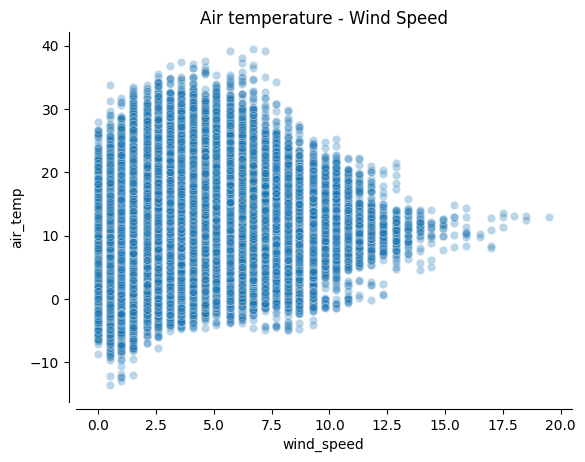

In [28]:
# df.plot.scatter(x='wind_speed',y='air_temp')
plot = sns.scatterplot(x='wind_speed',y='air_temp',data=df, alpha=0.3).set(
    title='Air temperature - Wind Speed'
)
sns.despine(offset=5)

plt.savefig(f'{EXPORT_FOLDER}/air_tempVSwind_speed.png', bbox_inches='tight', dpi=300)

## Calculate Maximum Temperature per Year / Direction

In [29]:
def q99(n):
  return n.quantile(0.999)

max_per_orientation = df.groupby(['norm_dir', df.date.dt.year]).air_temp.agg({'max', q99,'min'})
max_per_orientation


min   max      q99
norm_dir date                    
0        2002 -0.6  25.4  23.7731
         2003 -7.2  28.0  26.4722
         2004 -5.4  26.2  25.1979
         2005 -6.0  26.6  26.5000
         2006 -6.6  26.8  25.0240
...            ...   ...      ...
330      2018 -3.5  29.4  29.3236
         2019 -5.4  27.7  25.9162
         2020 -3.6  26.7  25.3512
         2021 -4.3  30.4  30.2068
         2022 -3.1  28.1  27.9944

[252 rows x 3 columns]

### Variation on maximum temperature per orientation

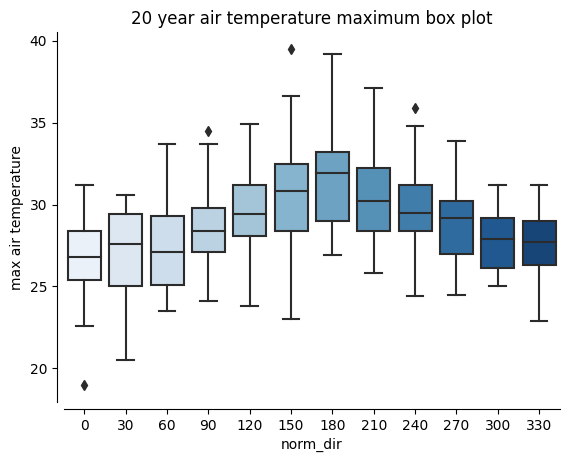

In [30]:
import seaborn as sns
flat = max_per_orientation.reset_index()
plot = sns.boxplot(x='norm_dir', y='max', data= flat, palette='Blues').set(
    title='20 year air temperature maximum box plot', 
    ylabel='max air temperature'
    )

sns.despine(offset=5)

plt.savefig(f'{EXPORT_FOLDER}/max_air_temp_box_plot.png', bbox_inches='tight', dpi=300)

### Download Zip File from Google Colab

In [32]:
!zip -r /content/file.zip /content/export/
try:
    from google.colab import files
    files.download("/content/file.zip")
except:
    print("Not running in Google Colab")
# zip and download file

Not running in Google Colab


'zip' is not recognized as an internal or external command,
operable program or batch file.
